In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۴ — مبانی یادگیری نظارت‌شده
## درس ۵: همه معیارهای ارزیابی مدل (MAE, MSE, RMSE, Accuracy, ...)

### چرا این درس مهم است
آموزش دادن یک مدل فقط نیمی از کار است. نیمهٔ دیگر، **اندازه‌گیری این است که «خوب» دقیقاً یعنی چه** برای مسئلهٔ مشخص شما. در یادگیری نظارت‌شده، ارزیابی مدل یعنی تبدیل پیش‌بینی‌ها به **شواهد**: مدل چقدر دقیق است، خطاهایش چه هزینه‌ای دارند، چقدر پایدار است، و در زمان استقرار چقدر قابل اعتماد عمل می‌کند.

این درس عمداً جامع نوشته شده است: رایج‌ترین معیارهای **طبقه‌بندی و رگرسیون** را یکجا جمع می‌کند، توضیح می‌دهد هر معیار در چه شرایطی مناسب است (و چه زمانی گمراه‌کننده می‌شود)، و نشان می‌دهد چگونه آن‌ها را به‌درستی با Python محاسبه کنید.

### اهداف یادگیری
در پایان این نوت‌بوک باید بتوانید:
1. تفاوت بین **خطای آموزش**، **خطای اعتبارسنجی** و **خطای آزمون** را توضیح دهید و بدانید چرا leakage (نشت اطلاعات) معیارها را خراب می‌کند.
2. معیارهایی را انتخاب کنید که با *هدف کسب‌وکار/علمی* شما هم‌راستا باشد (هزینه‌ها، عدم‌توازن، کالیبراسیون، ریسک).
3. معیارهای اصلی را برای موارد زیر محاسبه کنید:
   - رگرسیون: **MAE, MSE, RMSE, R², Adjusted R², MAPE, sMAPE, RMSLE (مفهومی)**
   - طبقه‌بندی: **Accuracy, Balanced Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC, Log Loss, Brier Score**
4. مفهوم **آستانه‌گذاری**، **هزینهٔ تصمیم** و انتخاب نقطهٔ عملیاتی را درک کنید.
5. معیارها را با **نمودارها** تفسیر کنید (confusion matrix، منحنی ROC، منحنی PR، منحنی کالیبراسیون).
6. نتایج را با **cross-validation** و **عدم‌قطعیت** (bootstrap confidence intervals) گزارش دهید.

### پیش‌نیازها
- Python پایه و pandas
- آشنایی با train/test split و مفهوم generalization
- درک پایه‌ای از تفاوت regression و classification

در طول درس، از چند دیتاست مختلف در مخزن شما (برای طبقه‌بندی و رگرسیون) استفاده می‌کنیم تا گرفتار الگوی اشتباه «یک دیتاست برای همهٔ بحث‌های ارزیابی» نشویم.


## ۱) یک چارچوب عملی برای ارزیابی

ارزیابی یک عدد واحد نیست؛ یک فرایند است. یک پروتکل ارزیابی خوب معمولاً پاسخ می‌دهد به:

۱. **هدف پیش‌بینی چیست؟** (کلاس دودویی، برچسب چندکلاسه، مقدار عددی)
۲. **پیامد اشتباهات چیست؟** (false positive در برابر false negative؛ خطای بزرگ در برابر خطای کوچک)
۳. **فرایند تولید داده چگونه است؟** (i.i.d. در برابر زمانی؛ گروه‌بندی بر اساس موجودیت‌ها؛ تغییر توزیع)
۴. **تصمیم زمان استقرار چیست؟** (برچسب قطعی در برابر نمره/احتمال؛ آستانه‌ها؛ رتبه‌بندی)
۵. **generalization را چگونه برآورد می‌کنید؟** (holdout test؛ cross-validation؛ split آگاه از زمان)

یک راه خلاصه برای صورت‌بندی ارزیابی این است که یک **تابع زیان** $\ell(y, \hat{y})$ تعریف کنید و سپس برآوردی از مقدار امیدریاضی آن گزارش دهید:

$$
\mathcal{R} = \mathbb{E}[\ell(Y, \hat{Y})]
$$

معیارهایی مثل MAE، MSE، Accuracy و Log Loss را می‌توان حالت‌های خاصی از برآورد empirical risk تحت توابع زیان متفاوت دانست.

### Train/Validation/Test: «قرارداد»
- **Training set**: برای برازش پارامترها استفاده می‌شود.
- **Validation set**: برای تنظیم hyperparameterها و تصمیم‌های مدل‌سازی استفاده می‌شود.
- **Test set**: (در حالت ایده‌آل) فقط یک بار برای برآورد عملکرد نهایی استفاده می‌شود.

اگر مدام به test set نگاه کنید، test دیگر test نیست؛ تبدیل به validation می‌شود. این کار معیارها را باد می‌کند و در تولید باعث ناامیدی می‌شود.

### یک نکته درباره leakage
Leakage یعنی هر نوع اطلاعاتی که در فرایند آموزش وارد شود ولی در زمان پیش‌بینی در دسترس نباشد. انواع رایج:
- **Feature leakage**: متغیرهای پس از وقوع outcome، target encoding نادرست، preprocessing قبل از split.
- **Split leakage**: حضور یک موجودیت مشترک در train و test (بیمار/کاربر/دستگاه)، یا نشت زمانی.
- **Evaluation leakage**: انتخاب مدل یا آستانه بر اساس test set.

این درس روی معیارها تمرکز دارد، اما همیشه یادتان باشد: **معیار عالی روی دادهٔ دارای leakage، یک دروغ عالی است**.


In [2]:
# Core imports (keep comments in English)
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    log_loss, brier_score_loss,
    mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
)

from sklearn.calibration import calibration_curve

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Ready.")


Ready.


In [3]:
def read_csv_safe(rel_path: str, **kwargs) -> pd.DataFrame:
    """Read a CSV from the repo-relative path. If missing, raise a helpful error."""
    if not os.path.exists(rel_path):
        raise FileNotFoundError(
            f"File not found: {rel_path}\n"
            "Make sure you are running this notebook inside your course repository, "
            "and that the Datasets/ folder matches the expected structure."
        )
    return pd.read_csv(rel_path, **kwargs)

def train_test_split_stratified(X, y, test_size=0.25, random_state=RANDOM_STATE):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred) + eps)
    return float(np.mean(2.0 * np.abs(y_pred - y_true) / denom))

def adjusted_r2(r2, n, p):
    """Adjusted R^2 for regression. n=number of samples, p=number of predictors."""
    return 1.0 - (1.0 - r2) * (n - 1) / max(n - p - 1, 1)


## ۲) خانواده‌های معیارها در یک نگاه

معیارهای مختلف به پرسش‌های متفاوت پاسخ می‌دهند. از این راهنمای سریع به‌عنوان نقطهٔ شروع استفاده کنید:

### Regression (هدف عددی)
- **MAE**: میانگین قدر مطلق خطا؛ قابل تفسیر در واحد اصلی؛ نسبتاً مقاوم در برابر outlier.
- **MSE / RMSE**: مربع خطا؛ خطاهای بزرگ را شدیدتر جریمه می‌کند؛ حساس به outlier.
- **R²**: میزان توضیح واریانس نسبت به baseline؛ ممکن است در مدل بد منفی شود.
- **MAPE / sMAPE**: خطای درصدی؛ نزدیک صفر مشکل‌ساز؛ با احتیاط استفاده شود.
- **Robust losses** (Huber، quantile loss): مناسب وقتی outlier زیاد است یا هزینه‌ها نامتقارن هستند.

### Classification (برچسب گسسته)
- **Accuracy**: درصد پیش‌بینی درست؛ در عدم‌توازن گمراه‌کننده می‌شود.
- **Balanced accuracy**: میانگین recall روی کلاس‌ها؛ در عدم‌توازن بهتر است.
- **Precision / Recall**: تفکیک false positive و false negative.
- **F1**: میانگین هارمونیک precision و recall؛ تمرکز بر عملکرد کلاس مثبت.
- **ROC-AUC**: کیفیت رتبه‌بندی در همهٔ آستانه‌ها؛ در عدم‌توازن شدید ممکن است خوش‌بینانه باشد.
- **PR-AUC (Average Precision)**: تمرکز بر بازیابی کلاس مثبت؛ معمولاً در عدم‌توازن ترجیح داده می‌شود.
- **Log Loss**: کیفیت احتمال‌ها را می‌سنجد؛ پیش‌بینی‌های خیلی مطمئن ولی غلط را شدیداً جریمه می‌کند.
- **Brier Score**: خطای مربعی احتمال‌ها؛ به کالیبراسیون مرتبط است.

### Probabilistic در برابر تصمیم قطعی
برخی معیارها (مثل Accuracy و F1) نیاز دارند با یک **threshold** احتمال را به برچسب تبدیل کنید.
برخی دیگر (مثل AUC، Log Loss و Brier) می‌توانند *نمره/احتمال* را مستقیماً ارزیابی کنند.


## ۳) مثال طبقه‌بندی دودویی: دیتاست Diabetes

ابتدا یک دیتاست طبقه‌بندی دودویی (`diabetes.csv`) را استفاده می‌کنیم.


In [4]:
diabetes_path = "../../../Datasets/Classification/diabetes.csv"
df_diabetes = read_csv_safe(diabetes_path)

print(df_diabetes.shape)
display(df_diabetes.head())


(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [5]:
target_col = "classification"
X = df_diabetes.drop(columns=[target_col])
y = df_diabetes[target_col]

# Basic numeric preprocessing: impute missing values (if any) and scale
numeric_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

X_train, X_test, y_train, y_test = train_test_split_stratified(X, y, test_size=0.25, random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

# Predicted labels and probabilities
y_pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)

classes = clf.named_steps["model"].classes_
pos_label = "Diabetic" if "Diabetic" in classes else classes[-1]
pos_index = int(np.where(classes == pos_label)[0][0])
y_score = proba[:, pos_index]

print("Classes:", classes)
print("Positive label assumed:", pos_label)


Classes: ['Diabetic' 'Non-Diabetic']
Positive label assumed: Diabetic


### ۳.۱ Confusion matrix و معیارهای مبتنی بر برچسب

برای طبقه‌بندی دودویی، confusion matrix معمولاً به شکل زیر بیان می‌شود:

- **TP**: true positive
- **TN**: true negative
- **FP**: false positive
- **FN**: false negative


In [6]:
cm = confusion_matrix(y_test, y_pred, labels=classes)

acc = accuracy_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=pos_label)
rec = recall_score(y_test, y_pred, pos_label=pos_label)
f1 = f1_score(y_test, y_pred, pos_label=pos_label)

print("Confusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(cm, index=[f"true_{c}" for c in classes], columns=[f"pred_{c}" for c in classes]))
print()
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bacc:.4f}")
print(f"Precision({pos_label}): {prec:.4f}")
print(f"Recall({pos_label}):    {rec:.4f}")
print(f"F1({pos_label}):        {f1:.4f}")
print()
print("Classification report:")
print(classification_report(y_test, y_pred))


Confusion matrix (rows=true, cols=pred):
                   pred_Diabetic  pred_Non-Diabetic
true_Diabetic                 40                 27
true_Non-Diabetic             14                111

Accuracy:          0.7865
Balanced accuracy: 0.7425
Precision(Diabetic): 0.7407
Recall(Diabetic):    0.5970
F1(Diabetic):        0.6612

Classification report:
              precision    recall  f1-score   support

    Diabetic       0.74      0.60      0.66        67
Non-Diabetic       0.80      0.89      0.84       125

    accuracy                           0.79       192
   macro avg       0.77      0.74      0.75       192
weighted avg       0.78      0.79      0.78       192



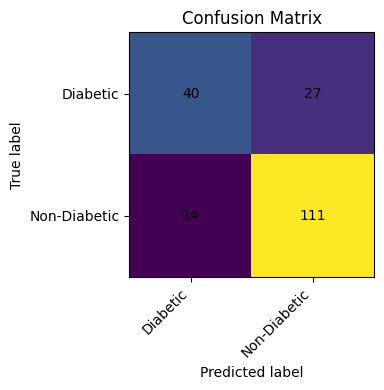

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix")
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()


### ۳.۲ Thresholding: تبدیل احتمال به تصمیم

برای تبدیل probability به برچسب، آستانه $t$ انتخاب می‌کنیم.


In [8]:
def predict_with_threshold(scores, threshold, positive_label=pos_label, negative_label=None):
    if negative_label is None:
        negative_label = [c for c in classes if c != positive_label][0]
    return np.where(scores >= threshold, positive_label, negative_label)

thresholds = np.linspace(0.05, 0.95, 19)
rows = []
C_FP = 1.0
C_FN = 5.0  # example: missing a diabetic case is 5x more costly

neg_label = [c for c in classes if c != pos_label][0]

for t in thresholds:
    y_hat = predict_with_threshold(y_score, t, positive_label=pos_label, negative_label=neg_label)
    cm_t = confusion_matrix(y_test, y_hat, labels=classes)

    idx_pos = int(np.where(classes == pos_label)[0][0])
    idx_neg = int(np.where(classes == neg_label)[0][0])
    TP = cm_t[idx_pos, idx_pos]
    TN = cm_t[idx_neg, idx_neg]
    FP = cm_t[idx_neg, idx_pos]
    FN = cm_t[idx_pos, idx_neg]

    cost = C_FP * FP + C_FN * FN
    f1_t = f1_score(y_test, y_hat, pos_label=pos_label)
    rec_t = recall_score(y_test, y_hat, pos_label=pos_label)
    prec_t = precision_score(y_test, y_hat, pos_label=pos_label)

    rows.append({"threshold": t, "F1": f1_t, "precision": prec_t, "recall": rec_t, "FP": FP, "FN": FN, "cost": cost})

df_thr = pd.DataFrame(rows).sort_values("threshold")
display(df_thr)

best_by_cost = df_thr.loc[df_thr["cost"].idxmin()]
best_by_f1 = df_thr.loc[df_thr["F1"].idxmax()]

print("Best threshold by expected cost:", dict(best_by_cost))
print("Best threshold by F1:", dict(best_by_f1))


,threshold,F1,precision,recall,FP,FN,cost
0,0.05,0.546939,0.376404,1.000000,111,0,111.0
1,0.10,0.598214,0.426752,1.000000,90,0,90.0
2,0.15,0.616915,0.462687,0.925373,72,5,97.0
3,0.20,0.655556,0.522124,0.880597,54,8,94.0
4,0.25,0.662651,0.555556,0.820896,44,12,104.0
5,0.30,0.662252,0.595238,0.746269,34,17,119.0
6,0.35,0.666667,0.635135,0.701493,27,20,127.0
7,0.40,0.666667,0.676923,0.656716,21,23,136.0
8,0.45,0.656000,0.706897,0.611940,17,26,147.0
9,0.50,0.661157,0.740741,0.597015,14,27,149.0


Best threshold by expected cost: {'threshold': np.float64(0.1), 'F1': np.float64(0.5982142857142857), 'precision': np.float64(0.4267515923566879), 'recall': np.float64(1.0), 'FP': np.float64(90.0), 'FN': np.float64(0.0), 'cost': np.float64(90.0)}
Best threshold by F1: {'threshold': np.float64(0.35), 'F1': np.float64(0.6666666666666666), 'precision': np.float64(0.6351351351351351), 'recall': np.float64(0.7014925373134329), 'FP': np.float64(27.0), 'FN': np.float64(20.0), 'cost': np.float64(127.0)}


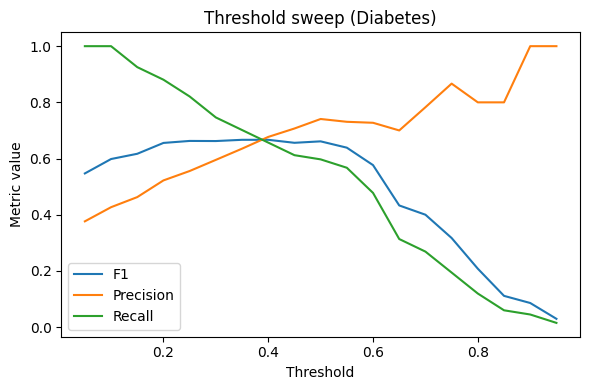

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_thr["threshold"], df_thr["F1"], label="F1")
ax.plot(df_thr["threshold"], df_thr["precision"], label="Precision")
ax.plot(df_thr["threshold"], df_thr["recall"], label="Recall")
ax.set_title("Threshold sweep (Diabetes)")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric value")
ax.legend()
plt.tight_layout()
plt.show()


## ۴) معیارهای مبتنی بر score و probability

### ۴.۱ ROC-AUC
### ۴.۲ PR-AUC (Average Precision)
### ۴.۳ Log Loss
### ۴.۴ Brier Score


In [10]:
# Convert y_test to binary {0,1} w.r.t. pos_label for probability metrics
y_true_bin = (y_test.values == pos_label).astype(int)

roc_auc = roc_auc_score(y_true_bin, y_score)
fpr, tpr, roc_thr = roc_curve(y_true_bin, y_score)

ap = average_precision_score(y_true_bin, y_score)
prec_curve, rec_curve, pr_thr = precision_recall_curve(y_true_bin, y_score)

ll = log_loss(y_true_bin, np.vstack([1-y_score, y_score]).T)
bs = brier_score_loss(y_true_bin, y_score)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC (Average Precision): {ap:.4f}")
print(f"Log Loss: {ll:.4f}")
print(f"Brier Score: {bs:.4f}")


ROC-AUC: 0.8236
PR-AUC (Average Precision): 0.6977
Log Loss: 0.4834
Brier Score: 0.1603


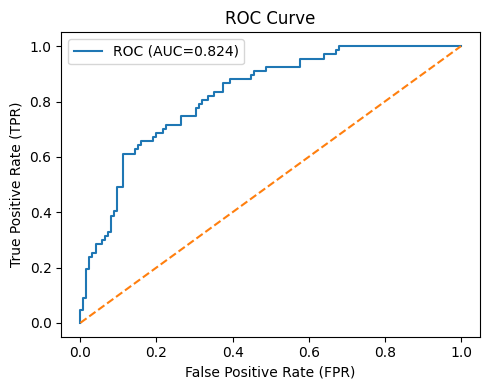

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("ROC Curve")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.legend()
plt.tight_layout()
plt.show()


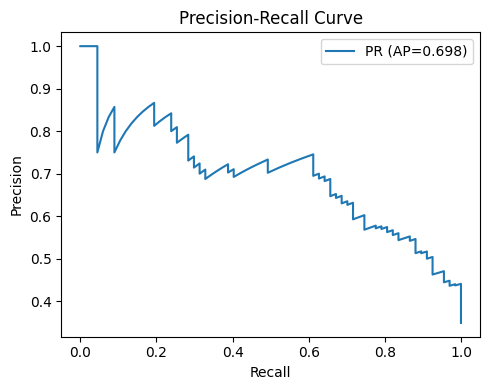

In [12]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(rec_curve, prec_curve, label=f"PR (AP={ap:.3f})")
ax.set_title("Precision-Recall Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
plt.tight_layout()
plt.show()


## ۵) Calibration: آیا probabilityها قابل اعتماد هستند؟

در ادامه یک calibration curve ساده را محاسبه و رسم می‌کنیم.


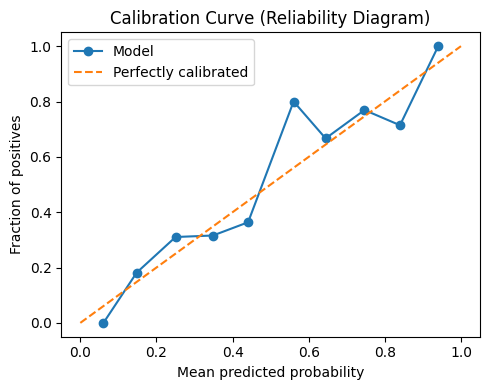

In [13]:
prob_true, prob_pred = calibration_curve(y_true_bin, y_score, n_bins=10, strategy="uniform")

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(prob_pred, prob_true, marker="o", label="Model")
ax.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
ax.set_title("Calibration Curve (Reliability Diagram)")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.legend()
plt.tight_layout()
plt.show()


## ۶) طبقه‌بندی چندکلاسه: دیتاست Iris

در این بخش یک logistic regression چندکلاسه روی Iris آموزش می‌دهیم.


In [14]:
iris_path = "../../../Datasets/Classification/iris.csv"
df_iris = read_csv_safe(iris_path)

display(df_iris.head())

target_col = "classification"
X = df_iris.drop(columns=[target_col])
y = df_iris[target_col]

numeric_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features)
    ]
)

# FIX: do NOT pass multi_class (deprecated in sklearn>=1.5; default is multinomial)
clf_mc = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

clf_mc.fit(X_train, y_train)
y_pred = clf_mc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Micro F1:", f1_score(y_test, y_pred, average="micro"))
print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))
print()
print(classification_report(y_test, y_pred))


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


Accuracy: 0.9210526315789473
Macro F1: 0.9229629629629629
Micro F1: 0.9210526315789473
Weighted F1: 0.9209356725146198

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.86      0.92      0.89        13
 Iris-virginica       0.92      0.85      0.88        13

       accuracy                           0.92        38
      macro avg       0.92      0.92      0.92        38
   weighted avg       0.92      0.92      0.92        38



## ۷) معیارهای رگرسیون: خطا روی هدف‌های پیوسته

### ۷.۶ مثال رگرسیون: دیتاست House Prices


In [15]:
house_path = "../../../Datasets/Regression/house-prices.csv"
df_house = read_csv_safe(house_path)

display(df_house.head())

target_col = "Price"
X = df_house.drop(columns=[target_col])
y = df_house[target_col]

# FIX: keep dedicated variables for CV/Bootstrap later (X and y will be reused later in the notebook)
X_house = X
y_house = y

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

reg.fit(X_train, y_train)
pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse_val = rmse(y_test, pred)
r2 = r2_score(y_test, pred)

# Approximate p as number of original predictors after encoding is not trivial.
# For a simple demo, use original column count.
p = X.shape[1]
adj_r2 = adjusted_r2(r2, n=len(y_test), p=p)

mape = mean_absolute_percentage_error(y_test, pred)
smape_val = smape(y_test, pred)

print(f"MAE:  {mae:,.2f}")
print(f"MSE:  {mse:,.2f}")
print(f"RMSE: {rmse_val:,.2f}")
print(f"R^2:  {r2:.4f}")
print(f"Adj R^2 (approx): {adj_r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"sMAPE:{smape_val:.4f}")


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


MAE:  8,326.54
MSE:  105,201,156.37
RMSE: 10,256.76
R^2:  0.8284
Adj R^2 (approx): 0.7783
MAPE: 0.0662
sMAPE:0.0662


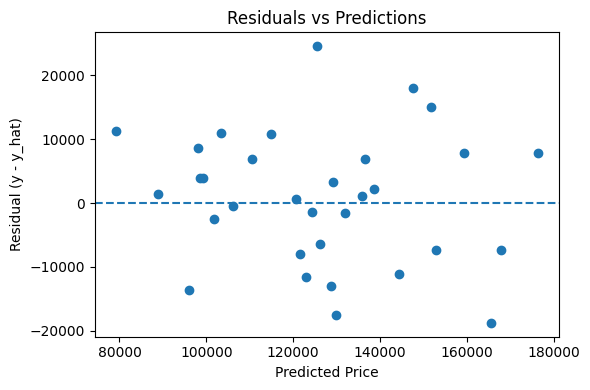

Residual summary:


count       32.000000
mean       772.296424
std      10391.297332
min     -18772.405357
25%      -7312.552257
50%       1301.573482
75%       7890.692039
max      24592.171380
Name: Price, dtype: float64

In [16]:
residuals = y_test - pred

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pred, residuals)
ax.axhline(0, linestyle="--")
ax.set_title("Residuals vs Predictions")
ax.set_xlabel("Predicted Price")
ax.set_ylabel("Residual (y - y_hat)")
plt.tight_layout()
plt.show()

print("Residual summary:")
display(pd.Series(residuals).describe())


### ۷.۷ مثال رگرسیون: دیتاست Diamonds


In [17]:
diamonds_path = "../../../Datasets/Regression/diamonds.csv"
df_diamonds = read_csv_safe(diamonds_path)

display(df_diamonds.head())

# Some versions store id as string with quotes; drop if present
df_diamonds = df_diamonds.copy()
if "id" in df_diamonds.columns:
    df_diamonds = df_diamonds.drop(columns=["id"])

# Optional sampling for speed
if len(df_diamonds) > 5000:
    df_diamonds = df_diamonds.sample(n=5000, random_state=RANDOM_STATE)

target_col = "price"
X = df_diamonds.drop(columns=[target_col])
y = df_diamonds[target_col]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ]
)

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

rf.fit(X_train, y_train)
pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse_val = rmse(y_test, pred)
r2 = r2_score(y_test, pred)
mape = mean_absolute_percentage_error(y_test, pred)
smape_val = smape(y_test, pred)

print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse_val:,.2f}")
print(f"R^2:  {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"sMAPE:{smape_val:.4f}")


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


MAE:  384.83
RMSE: 755.26
R^2:  0.9662
MAPE: 0.0967
sMAPE:0.0934


## ۸) Cross-validation و عدم‌قطعیت در معیارها


In [18]:
# Cross-validation on the house prices regression pipeline (5-fold)
# FIX: use X_house/y_house because X/y are reused later in the notebook.
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scores_neg_mae = cross_val_score(reg, X_house, y_house, scoring="neg_mean_absolute_error", cv=kf)
scores_rmse = np.sqrt(-cross_val_score(reg, X_house, y_house, scoring="neg_mean_squared_error", cv=kf))

print("CV MAE (neg):", scores_neg_mae)
print(f"CV MAE mean: {-scores_neg_mae.mean():.2f}  std: {scores_neg_mae.std():.2f}")
print()
print("CV RMSE:", scores_rmse)
print(f"CV RMSE mean: {scores_rmse.mean():.2f}  std: {scores_rmse.std():.2f}")


CV MAE (neg): [-8843.25380419 -6868.93619527 -9663.87841368 -6268.56636983
 -7180.40833413]
CV MAE mean: 7765.01  std: 1276.90

CV RMSE: [10647.43187502  9271.88757646 12038.20527304  8299.62366595
  9666.36580955]
CV RMSE mean: 9984.70  std: 1273.19


Test MAE: 8326.54
Bootstrap 95% CI for MAE: [6301.43, 10445.79]


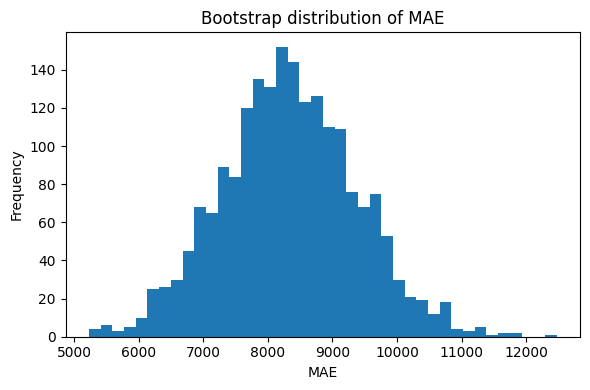

In [19]:
# Bootstrap CI for test MAE (house prices example)
# FIX: use X_house/y_house
rng = np.random.default_rng(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X_house, y_house, test_size=0.25, random_state=RANDOM_STATE)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

errors = np.abs(y_test.values - pred)
n = len(errors)

B = 2000
boot_mae = np.empty(B)
for b in range(B):
    idx = rng.integers(0, n, size=n)
    boot_mae[b] = errors[idx].mean()

ci_low, ci_high = np.percentile(boot_mae, [2.5, 97.5])
print(f"Test MAE: {errors.mean():.2f}")
print(f"Bootstrap 95% CI for MAE: [{ci_low:.2f}, {ci_high:.2f}]")

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(boot_mae, bins=40)
ax.set_title("Bootstrap distribution of MAE")
ax.set_xlabel("MAE")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()


## ۹) انتخاب معیار مناسب: یک چک‌لیست تصمیم

### گام A — نوع پیش‌بینی
- **Regression**: هدف عددی → MAE/RMSE/R² و هزینه‌های حوزه را در نظر بگیرید.
- **Classification**: برچسب گسسته → عدم‌توازن و هزینهٔ تصمیم مهم است.
- **به probability/risk score نیاز دارید؟** → Log Loss/Brier + نمودارهای calibration را ترجیح دهید.

### گام B — هم‌راستایی با هزینهٔ خطا
- اگر **خطاهای بزرگ فاجعه‌آمیز هستند**: RMSE اطلاعات بیشتری می‌دهد.
- اگر **مقاومت به outlier** مهم است: MAE یا زیان‌های مقاوم مناسب‌ترند.
- اگر **false negative گران است**: Recall را برجسته کنید یا آستانه را مطابق هزینه تنظیم کنید.
- اگر **false positive گران است**: Precision را برجسته کنید.

### گام C — عدم‌توازن کلاس‌ها (در طبقه‌بندی)
- به Accuracy به‌تنهایی تکیه نکنید.
- Precision/Recall/F1 و balanced accuracy را گزارش کنید.
- وقتی positives نادر هستند، PR-AUC معمولاً مناسب‌تر از ROC-AUC است.

### گام D — سیاست تصمیم
- اگر خروجی **برچسب** است: معیارهای وابسته به آستانه (F1، precision، recall) را گزارش کنید و آستانه را ذکر کنید.
- اگر خروجی **score/probability** است: AUC/Log Loss/Brier و calibration را گزارش کنید.

### گام E — عدم‌قطعیت و بازتولیدپذیری
- از CV یا چند split استفاده کنید.
- random seed را ثابت کنید.
- وقتی قرار است مدل‌ها مقایسه یا نتیجه منتشر شود، CI ارائه دهید.


## ۱۰) تمرین‌ها (پیشنهادی)

۱) **تلهٔ Accuracy** ...
۲) **تنظیم آستانه** ...
۳) **بررسی Calibration** ...
۴) **Macro در برابر Micro** ...
۵) **MAE در برابر RMSE** ...
۶) **حاشیهٔ صفر در MAPE** ...
۷) **Bootstrap CI** ...
۸) **انتخاب مدل بر اساس معیار** ...
۹) **قالب گزارش معیار** ...
۱۰) **یادداشت حکمرانی (Governance)** ...


## جمع‌بندی

- معیارها قابل جایگزینی نیستند؛ هر معیار فرض‌هایی دربارهٔ هزینه و داده دارد.
- همیشه **ارزیابی probability** را از **ارزیابی تصمیم** جدا کنید.
- در عدم‌توازن، روی **precision/recall** و **PR-AUC** تمرکز کنید.
- در رگرسیون، انتخاب MAE در برابر RMSE یک انتخاب سیاستی است.
- از cross-validation و bootstrap برای فهم تغییرپذیری استفاده کنید.
